# VIDEO PIPELINE - detect poacher on an inputed video 
----

## Load packages

In [2]:
from poacher.model import (yolo_loss)
from poacher import utils
from poacher import config
from poacher import metrics

import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from tensorflow.keras import backend as K

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc
from IPython.display import display

In [3]:
print('tensorflow version:', tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.per_process_gpu_memory_fraction = 0.3
    print('Using GPU')

tensorflow version: 2.1.0


## Load model

In [4]:
def load_model(model_path):
    
    t0 = time.time()
    model = tf.keras.models.load_model(model_path, compile=False)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(optimizer=optimizer, 
                  loss={
                      'tf_op_layer_concat_4': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 52x52
                      'tf_op_layer_concat_7': lambda y_true, y_pred: yolo_loss(y_true, y_pred), # 26x26
                      'tf_op_layer_concat_10': lambda y_true, y_pred: yolo_loss(y_true, y_pred),# 13x13
                  }
                 )
    print('model loaded in %.2fs'%(time.time() - t0))
    return model

In [5]:
model_path = 'save/20200417_model_trained.h5'
model = load_model(model_path)
gc.collect()

model loaded in 7.96s


0

In [6]:
model.output

[<tf.Tensor 'tf_op_layer_concat_4/Identity:0' shape=(None, None, None, None, None) dtype=float32>,
 <tf.Tensor 'tf_op_layer_concat_7/Identity:0' shape=(None, None, None, None, None) dtype=float32>,
 <tf.Tensor 'tf_op_layer_concat_10/Identity:0' shape=(None, None, None, None, None) dtype=float32>]

In [7]:
# model.summary()

## Load video and predict

In [8]:
def get_next_frame(vid):
    """
    """
    # Get next frame
    return_value, frame = vid.read()
    
    # If there is a frame then change color scale
    if return_value:
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame
    else:
        return None
    
def image_preprocess(image, target_size):

    ih, iw    = target_size
    h,  w, _  = image.shape

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    return image_paded

def get_image_preprocess(frame):

    input_size = config.INPUT_SIZE
    # Preprocess image (change size and convert to np array)
    frame_size = frame.shape[:2]
    image_data = image_preprocess(np.copy(frame), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    
    return image_data

def predict(X, model):
    t0 = time.time()
    pred = model.predict_on_batch(X)
    return pred, time.time() - t0

def postprocess_pred_bbox(pred_bbox, frame_size):
    
    input_size = config.INPUT_SIZE
    threshold = config.THRESHOLD
    
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    
    bboxes = utils.postprocess_boxes(pred_bbox, frame_size, input_size, threshold)
    
    # Keep only person object prediction
    bboxes = bboxes[bboxes[..., 5] == 0]

    bboxes = utils.nms(bboxes, 0.45, method='nms')    
    return bboxes


In [13]:
def main(video_path, out_path='test.mp4', break_at=60, frames_to_ignore=0, verbose=None):
    """
    """
    t_start = time.time()
    vid = cv2.VideoCapture(video_path)
    fps = round(vid.get(cv2.CAP_PROP_FPS),0)
    
    times = {
        'next frame': list(),
        'write time': list(),
        'preprocess time': list(),
        'pred time': list(),
        'postprocess time': list(),
        'draw bboxes time': list()
    }
    frames_analysed = 0
    
    cnt = 0
    # get first frame
    frame = get_next_frame(vid)
    
    # video resolution
    height, width = frame.shape[:2]
    
    frames_hist = list()
    
    print('Original video: %ix%i and %i fps'%(width, height, fps))
    
    out = cv2.VideoWriter(out_path, 
                          cv2.VideoWriter_fourcc(*'DIVX'), 
                          fps, (width, height))
    
    print('Ready to analyse video at %.2fs'%(time.time()-t_start))
    pred_bbox = []
    
    while frame is not None:
        
        if cnt%(frames_to_ignore+1) == 0:
            # Preprocess frame
            t0 = time.time()
            image_data = get_image_preprocess(frame)
            times['preprocess time'].append(time.time() - t0)

            # Predict
            pred_bbox, t = predict(image_data, model)
            times['pred time'].append(t)
            
            # Postprocess to know if there is any poacher on the image
            t0 = time.time()
            pred_bbox = postprocess_pred_bbox(pred_bbox, [height, width])
            times['postprocess time'].append(time.time() - t0)
            
            if verbose is not None:
                print('frame n°%i : %i poacher(s) detected'%(cnt, len(pred_bbox)))
            
            frames_analysed += 1
            gc.collect()
            
        
        # Draw box on image
        t0 = time.time()
        frame = utils.draw_bbox(frame, pred_bbox)
        times['draw bboxes time'].append(time.time() - t0)
        
        t0 = time.time()
        out.write(frame)
        times['write time'].append(time.time() - t0)
        
        t0 = time.time()
        frame = get_next_frame(vid)
        times['next frame'].append(time.time() - t0)
        
        cnt += 1
        if cnt%fps == 0:
            print(cnt,'frames : %.2fs'%(time.time()-t_start))
            gc.collect()
        
        # Break if ask
        if break_at is not None:
            if cnt >= break_at:
                break
                
    vid.release()
    out.release()
    
    print('==================')
    print('Script ended in %.2fs'%(time.time() - t_start))
    print('Average time of writing into out video (%i frames) : %.3fs (std %.4f)'%(
        cnt, np.mean(times['write time']), np.std(times['write time'])))
    print('Average time of getting next frame (%i frames) : %.3fs (std %.4f)'%(
        cnt, np.mean(times['next frame']), np.std(times['next frame'])))
    print('Average time of preprocessing a frame (%i frames) : %.3fs (std %.4f)'%(
        frames_analysed, np.mean(times['preprocess time']), np.std(times['preprocess time'])))
    print('Average time of prediction on a frame (%i frames) : %.3fs (std %.4f)'%(
        frames_analysed, np.mean(times['pred time']), np.std(times['pred time'])))
    print('Average time of postprocess bboxes (%i frames) : %.3fs (std %.4f)'%(
        frames_analysed, np.mean(times['postprocess time']), np.std(times['postprocess time'])))
    print('Average time of drawing bboxes on a frame (%i frames) : %.3fs (std %.4f)'%(
        cnt, np.mean(times['draw bboxes time']), np.std(times['draw bboxes time'])))
    return times

In [14]:
video_path = "/data/archives/1.1.11.MP4"
# video_path = "/data/archives/1.1.1.mov"
# video_path = "/data/savane_1min.mp4"

In [15]:
gc.collect()
times = main(video_path, break_at=None, frames_to_ignore=1, verbose=None)

Original video: 3840x2160 and 30 fps
Ready to analyse video at 0.68s
30 frames : 11.30s
60 frames : 23.04s
90 frames : 34.04s
120 frames : 44.68s
150 frames : 55.65s
180 frames : 66.19s
210 frames : 76.50s
240 frames : 87.01s
270 frames : 97.53s
300 frames : 108.18s
330 frames : 118.92s
360 frames : 129.44s
390 frames : 139.98s
420 frames : 151.02s
450 frames : 161.97s
480 frames : 172.94s
510 frames : 183.97s
540 frames : 195.03s
570 frames : 206.00s
600 frames : 217.14s
Script ended in 218.72s
Average time of writing into out video (604 frames) : 0.083s (std 0.0086)
Average time of getting next frame (604 frames) : 0.021s (std 0.0121)
Average time of preprocessing a frame (302 frames) : 0.009s (std 0.0016)
Average time of prediction on a frame (302 frames) : 0.374s (std 0.0290)
Average time of postprocess bboxes (302 frames) : 0.007s (std 0.0009)
Average time of drawing bboxes on a frame (604 frames) : 0.001s (std 0.0008)


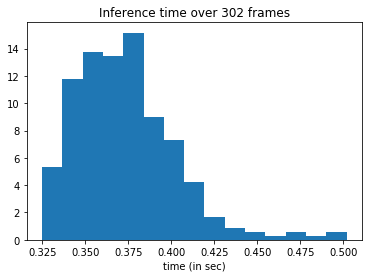

In [25]:
import matplotlib.pyplot as plt

preds_time = times['pred time']
plt.hist(preds_time, 15, density=True)
plt.title('Inference time over 302 frames')
plt.xlabel('time (in sec)')
plt.show()